# Measures of overall disasterness
I'll generate a combined measure based on the number of NOAA extreme weather events and earthquakes above magnitude 4.0.  Each county will get a number that is normalized to the area of that county.

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np

# Custom function for displaying the shape and head of a dataframe
def display(df, n=5):
    print(df.shape)
    return df.head(n)

## Get county data

In [2]:
# Import a shape file with all the counties in the US.
# Note how it doesn't include all the same territories as the 
# quake contour map.
counties = geopandas.read_file('../data_input/1_USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)
    
# Add a column for the area of each county. I'm using arbitrary area
# units rather than figuring out how geopandas codes that.  This 
# makes sense because I only care about relative areas, not absolutes.
counties['area'] = counties['geometry'].area
    
display(counties)

(3141, 7)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,area
0,Lake of the Woods,Minnesota,27,77,27077,"POLYGON ((-95.34283127277658 48.546679319076, ...",0.565450
1,Ferry,Washington,53,19,53019,POLYGON ((-118.8516288013387 47.94956368481996...,0.718059
2,Stevens,Washington,53,65,53065,"POLYGON ((-117.438831576286 48.04411548512263,...",0.795486
3,Okanogan,Washington,53,47,53047,"POLYGON ((-118.972093862835 47.93915200536639,...",1.669110
4,Pend Oreille,Washington,53,51,53051,POLYGON ((-117.4385804303028 48.99991850672649...,0.455726


In [3]:
# I normalize by area because some counties are enormous.
# Note the max here, which is that one giant county in Alaska
counties.area.describe()

count    3141.000000
mean        0.348960
std         1.804540
min         0.000465
25%         0.116861
50%         0.166589
75%         0.249554
max        73.829451
dtype: float64

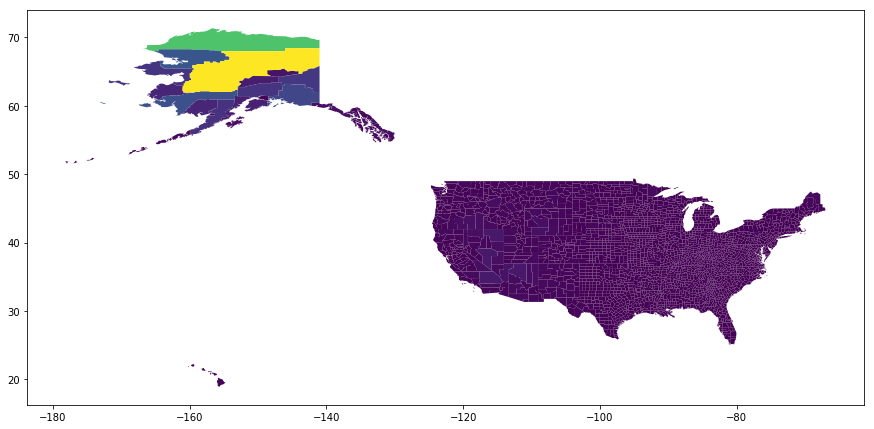

In [4]:
counties.plot(column='area', figsize=(15,15));

# Map disasters to counties
Join the disaster data with the county data and normalize by county area.

In [5]:
disasters = pd.read_csv('../data_output/6__danger/noaa_plus_quakes.csv')
display(disasters)

(72243, 11)


,year,FIPS,Winter Weather,Storm,Flood,Fire,Heat,Drought,Tornado,Hurricane,earthquakes
0,1996,1001,3,6,2,0,1,0,0,0,0
1,1996,1003,0,18,2,0,0,0,0,0,0
2,1996,1005,2,1,0,0,1,0,0,0,0
3,1996,1007,4,5,2,0,1,0,0,0,0
4,1996,1009,4,17,0,0,1,0,0,0,0


In [6]:
# Group by FIPS, thus combining all years
dis2 = disasters.groupby(['FIPS']).sum().drop(columns='year')
display(dis2)

(3141, 9)


,Winter Weather,Storm,Flood,Fire,Heat,Drought,Tornado,Hurricane,earthquakes
FIPS,,,,,,,,,
1001,17,225,28,0,5,36,26,0,0
1003,5,322,100,0,0,0,40,0,0
1005,7,120,7,0,8,49,22,0,0
1007,18,131,17,0,5,34,16,0,0
1009,33,312,37,0,4,29,30,0,0


In [7]:
# Add to the dataframe of counties and their geometries
dis3 = counties.merge(dis2, on='FIPS').set_index('FIPS').sort_index()
    
# Create a single measure of overall danger by adding up all the events
# for that county since 1996.

disaster_cols = ['Winter Weather', 'Storm', 'Flood', 'Fire', 'Heat', 'Drought',
       'Tornado', 'Hurricane', 'earthquakes']

dis3['danger'] = dis3[disaster_cols].sum(axis=1)

display(dis3)

(3141, 16)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,geometry,area,Winter Weather,Storm,Flood,Fire,Heat,Drought,Tornado,Hurricane,earthquakes,danger
FIPS,,,,,,,,,,,,,,,,
1001,Autauga,Alabama,1,1,POLYGON ((-86.82066986329349 32.34730960076057...,0.148903,17,225,28,0,5,36,26,0,0,337
1003,Baldwin,Alabama,1,3,POLYGON ((-87.97308978075395 31.16482251520438...,0.404489,5,322,100,0,0,0,40,0,0,467
1005,Barbour,Alabama,1,5,POLYGON ((-85.74337279655801 31.62624052460075...,0.222431,7,120,7,0,8,49,22,0,0,213
1007,Bibb,Alabama,1,7,POLYGON ((-87.41985563876936 33.01177307648309...,0.157736,18,131,17,0,5,34,16,0,0,221
1009,Blount,Alabama,1,9,POLYGON ((-86.96799449037186 33.86045466926403...,0.167530,33,312,37,0,4,29,30,0,0,445


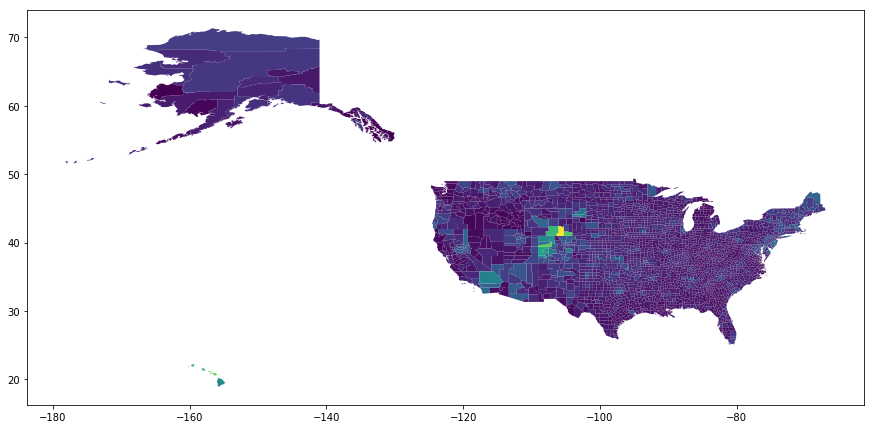

In [8]:
dis3.plot(column='danger', figsize=(15,15), legend=False);

In [9]:
dis4 = dis3[['danger','geometry']]
display(dis4)

(3141, 2)


,danger,geometry
FIPS,,
1001,337,POLYGON ((-86.82066986329349 32.34730960076057...
1003,467,POLYGON ((-87.97308978075395 31.16482251520438...
1005,213,POLYGON ((-85.74337279655801 31.62624052460075...
1007,221,POLYGON ((-87.41985563876936 33.01177307648309...
1009,445,POLYGON ((-86.96799449037186 33.86045466926403...


In [10]:
# Export as geoJSON file
dis4.to_file("../data_output/6__danger/danger.geojson", driver='GeoJSON')

In [11]:
# Export as CSV
dis5 = dis4.drop(columns='geometry')
dis5.to_csv("../data_output/6__danger/danger.csv")

# Generating disaster level labels

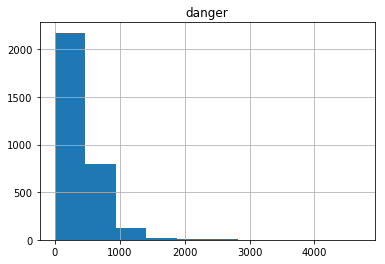

In [19]:
# Histogram to visualize the distribution of danger scores
dis5.hist();

Danger levels have a long-tailed distribution, so it's probably better to assign an overall danger score based on the log of danger rather than danger itself.

In [49]:
# Generate new dataframe
dis6 = dis4.copy()

# Generate new column with the log of danger.
dis6['log_danger'] = np.log(dis6['danger'] + 1)

In [50]:
# Create an array of numerical bins
danger_bins_numerical = pd.cut(dis6['log_danger'], bins=6, retbins=False, labels=False)

# Create an array of labeled bins
danger_bins_labels = pd.cut(dis6['log_danger'], bins=6, retbins=True, labels=['Boring','Calm','Reasonable','Exciting','Challenging','Get out!'])[0]

In [51]:
dis6['bins_num'] = danger_bins_numerical
dis6['bins_labels'] = danger_bins_labels

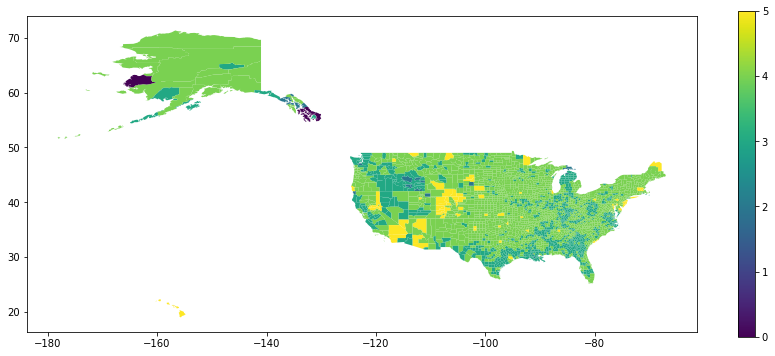

In [56]:
dis6.plot(column='bins_num', figsize=(15,6), legend=True);

In [58]:
dis6.head()

,danger,geometry,bins_num,bins_labels,log_danger
FIPS,,,,,
1001,337,POLYGON ((-86.82066986329349 32.34730960076057...,4,Challenging,5.823046
1003,467,POLYGON ((-87.97308978075395 31.16482251520438...,4,Challenging,6.148468
1005,213,POLYGON ((-85.74337279655801 31.62624052460075...,3,Exciting,5.365976
1007,221,POLYGON ((-87.41985563876936 33.01177307648309...,3,Exciting,5.402677
1009,445,POLYGON ((-86.96799449037186 33.86045466926403...,4,Challenging,6.100319


In [59]:
dis7 = dis6[['bins_num','bins_labels']]